# Import Data and Libraries

In [2]:
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

import cdsapi
import sklearn_pandas as skp

custom_colors = ['#68A33E', '#A10702', '#FB9E60', '#FFFF82', '#0F0326']

# Load in Raw Data

In [3]:
input_filename = './FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
        NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID,
        NWCG_REPORTING_UNIT_NAME,
        FIRE_NAME,
        COMPLEX_NAME,
        FIRE_YEAR,
        DISCOVERY_DATE,
        DISCOVERY_DOY,
        DISCOVERY_TIME,
        CONT_DATE,
        CONT_DOY,
        CONT_TIME,
        FIRE_SIZE,
        FIRE_SIZE_CLASS,
        OWNER_CODE,
        OWNER_DESCR,
        LATITUDE,
        LONGITUDE,
        STATE,
        COUNTY
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 20 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   NWCG_REPORTING_AGENCY     object 
 1   NWCG_REPORTING_UNIT_ID    object 
 2   NWCG_REPORTING_UNIT_NAME  object 
 3   FIRE_NAME                 object 
 4   COMPLEX_NAME              object 
 5   FIRE_YEAR                 int64  
 6   DISCOVERY_DATE            float64
 7   DISCOVERY_DOY             int64  
 8   DISCOVERY_TIME            object 
 9   CONT_DATE                 float64
 10  CONT_DOY                  float64
 11  CONT_TIME                 object 
 12  FIRE_SIZE                 float64
 13  FIRE_SIZE_CLASS           object 
 14  OWNER_CODE                float64
 15  OWNER_DESCR               object 
 16  LATITUDE                  float64
 17  LONGITUDE                 float64
 18  STATE                     object 
 19  COUNTY                    object 
dtypes: float64(7), int64(2),

In [4]:
input_filename = './FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
       *
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

# Clean Data and Extract Oregon Boundaries

In [5]:
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME', 
                'OWNER_DESCR',
                'OWNER_CODE']
df_US= df_raw.drop(columns= drop_columns)
df_US['MONTH'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_US['DAY'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])

In [124]:
from shapely.geometry import Point
# Assuming df_raw has columns 'LATITUDE' and 'LONGITUDE'
geometry = [Point(xy) for xy in zip(df_US['LONGITUDE'], df_US['LATITUDE'])]

# Create a GeoDataFrame with the geometry and assign it to df_geo
df_geo = gpd.GeoDataFrame(df_US, geometry=geometry)

# Assign a CRS to the GeoDataFrame
# For example, if your data is in WGS 84 (EPSG:4326), you can do:
df_geo.crs = "EPSG:4326"

# Now df_geo has a CRS assigned to it
print(df_geo.crs)


EPSG:4326


In [10]:
import altair as alt
from vega_datasets import data
states = alt.topo_feature(data.us_10m.url, feature='states')

In [19]:
us_states = gpd.read_file("./cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
states_us = gpd.read_file("./states.json")
oregon = us_states[us_states['NAME'] == 'Oregon']
states_us.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
df_grouped = df_geo.groupby(['STATE'], as_index=False).agg({'LATITUDE': 'mean', 'LONGITUDE': 'mean', 'FIRE_SIZE': 'sum' })

states = alt.topo_feature(data.us_10m.url, feature='states')

import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')

# US states background
back = alt.Chart(states_us).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('identity')

# Scatter plot with the aggregated data
map = alt.Chart(df_grouped).mark_circle().encode(
    x='LONGITUDE:Q',
    y='LATITUDE:Q',
    size=alt.Size('FIRE_SIZE:N', legend=None),
    tooltip=['STATE:N', 'FIRE_SIZE:N']
).properties(
    width=500,
    height=300
).project('identity')

# Combine the background map and the scatter plot
(back + map)


alt.LayerChart(...)

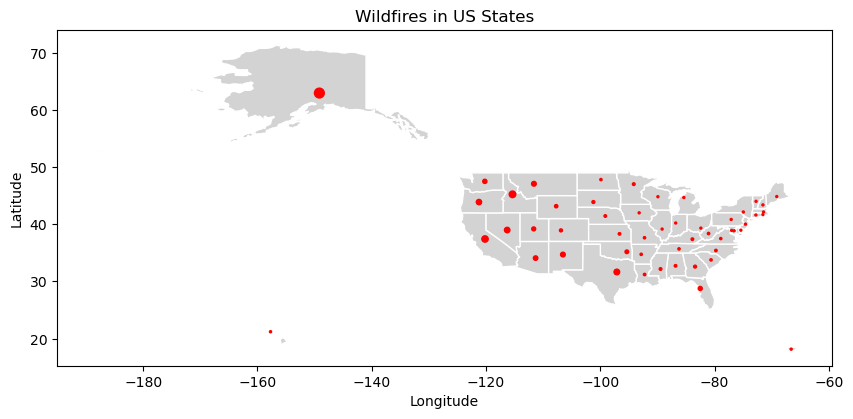

In [58]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler

# Create a GeoDataFrame for the aggregated data
geometry = [Point(xy) for xy in zip(df_grouped['LONGITUDE'], df_grouped['LATITUDE'])]
gdf = gpd.GeoDataFrame(df_grouped, geometry=geometry)

# Normalize 'FIRE_SIZE' to a range between 1 and 10
scaler = MinMaxScaler(feature_range=(2, 50))
gdf['markersize'] = scaler.fit_transform(gdf[['FIRE_SIZE']])

# Plot the US states boundaries
fig, ax = plt.subplots(figsize=(10, 6))
states_us.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the scatter plot of wildfires with variable markersize
gdf.plot(ax=ax, marker='o', color='red', markersize='markersize', legend=True)

# Customize the plot
ax.set_title('Wildfires in US States')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(False)

plt.show()


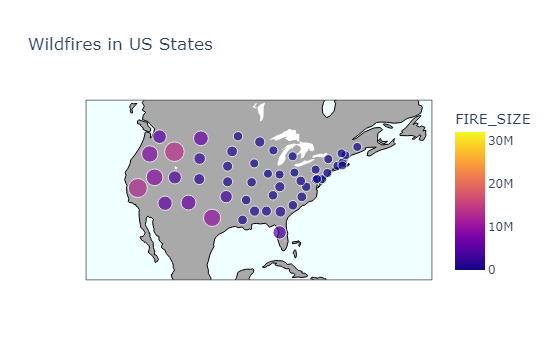

In [103]:
import plotly.express as px
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

# Assuming df_grouped is your DataFrame with aggregated data
# Replace this with your actual data loading process
# df_grouped = ...

# Normalize 'FIRE_SIZE' to a range between 1 and 10
scaler = MinMaxScaler(feature_range=(1, 10))
df_grouped['markersize'] = scaler.fit_transform(df_grouped[['FIRE_SIZE']])


# Create an interactive scatter plot using plotly express
fig = px.scatter_geo(
    df_grouped,
    locations='STATE',
    locationmode='USA-states',
    color='FIRE_SIZE',
    size='markersize',
    hover_name='STATE',
    projection='natural earth',
    title='Wildfires in US States',
    template='plotly',
)

# Set the center and scope for North America
fig.update_geos(
    center=dict(lon=-100, lat=40),
    projection_scale=2,
)
# Add state borders
fig.update_geos(
    showcoastlines=True,
    coastlinecolor='black',
    showsubunits=True,
    subunitcolor='black',
    subunitwidth=2,  # Adjust the width of state borders
    landcolor='darkgrey',
    showocean=True,
    oceancolor='azure',
)

# Show the interactive plot
fig.show()


In [109]:
import folium
from folium.plugins import MarkerCluster

# Assuming df_grouped is your DataFrame with aggregated data
# Replace this with your actual data loading process
# df_grouped = ...

# Load US states boundaries GeoJSON data
us_states_geojson = 'states.json'  # Replace with the actual file path

# Create a folium map centered at North America
m = folium.Map(location=[40, -95], zoom_start=4)

# Add US states boundaries to the map
folium.GeoJson(
    us_states_geojson,
    name='geojson'
).add_to(m)

# Create a MarkerCluster layer for wildfires
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each state
for index, row in df_grouped.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"State: {row['STATE']}\nFire Size: {row['FIRE_SIZE']:.2f}",
        icon=None,  # You can customize the icon here
    ).add_to(marker_cluster)

# Display the map
m.save('wildfires_map.html')  # Save the map as an HTML file

m

# Monthly/Seasonaly fire frequency

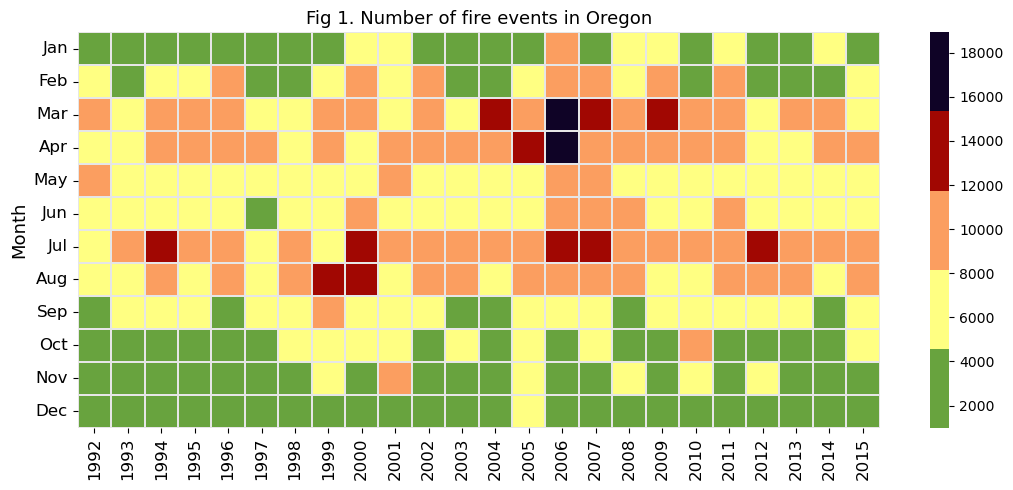

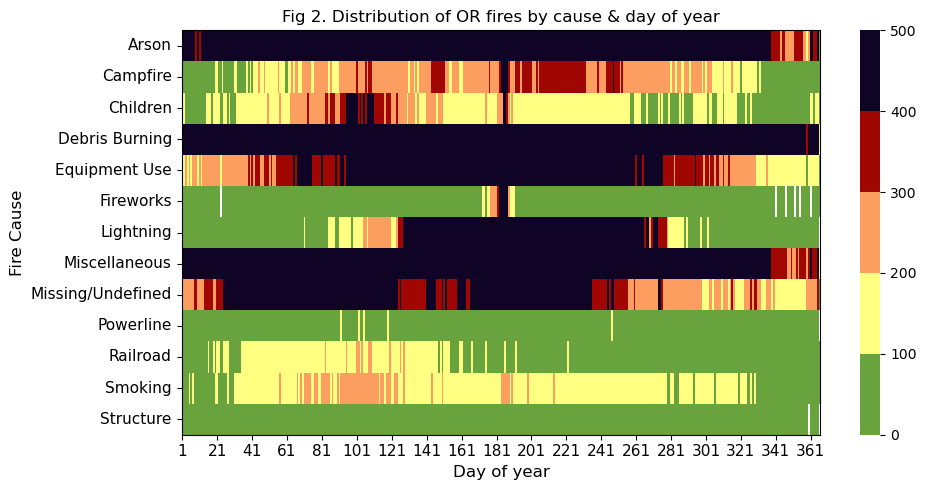

In [115]:
custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors
df_freq_mon = df_geo.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
df_freq_mon.to_csv("wildfireDataUS.csv")
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in US', fontsize=13)
plt.tight_layout()

# plot fire frequency by cause and day of year
cause_by_doy = df_geo.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of US fires by cause & day of year')
plt.tight_layout()


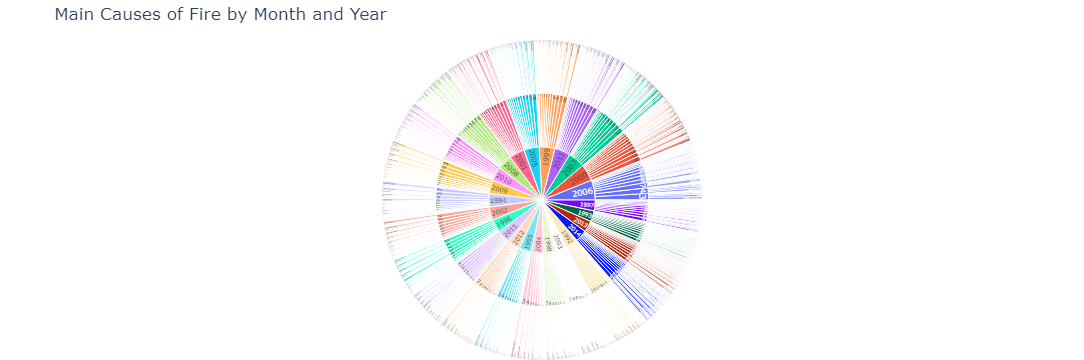

In [142]:
import plotly.express as px
# Create a sunburst chart showing the main causes of fire for a given month and year
fig = px.sunburst(df_geo, path=['FIRE_YEAR', 'MONTH', 'STAT_CAUSE_DESCR'], title='Main Causes of Fire by Month and Year')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))  # Adjust layout if needed
fig.show()


In [151]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# Create a frequency heatmap
heatmap_freq = px.imshow(df_geo)
heatmap_freq.update_layout(title='Monthly Frequency of Fire Events in US')

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    # Top heatmap (monthly frequency)
    dcc.Graph(id='heatmap-freq', figure=heatmap_freq),

    # Bottom heatmap (causes for a specific month and year)
    dcc.Graph(id='heatmap-causes'),

    # Hidden div to store selected month and year
    html.Div(id='selected-month-year', style={'display': 'none'})
])

# Define callback to update the bottom heatmap based on the selected month and year
@app.callback(
    Output('heatmap-causes', 'figure'),
    [Input('heatmap-freq', 'selectedData')]
)
def update_heatmap_causes(selectedData):
    # If no data is selected, use the entire dataset
    if selectedData is None:
        selected_month, selected_year = int(df_freq_mon.columns[-1]), int(df_freq_mon.index[-1])  # Default to the latest month and year
    else:
        # Extract the selected month and year from the heatmap
        selected_month, selected_year = int(selectedData['points'][0]['y']), int(selectedData['points'][0]['x'])

    # Filter the dataset for the selected month and year
    df_selected = df_geo[(df_geo['MONTH'] == selected_month) & (df_geo['FIRE_YEAR'] == selected_year)]

    # Create a causes heatmap for the selected month and year
    heatmap_causes = px.imshow(
        df_selected.groupby(['STAT_CAUSE_DESCR', 'DISCOVERY_DOY']).size().unstack(),
        cmap=custom_colors,
        title=f'Causes of Fire in {selected_month}, {selected_year}'
    )

    return heatmap_causes

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [186]:
df_OR = df_geo[df_raw.STATE == 'OR']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_OR.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,MONTH,DAY,geometry
31,32,32,FS-1418907,FED,FS-FIRESTAT,0601,Deschutes National Forest,1,1-001,BJ9H,None,None,None,None,2005,2453406.5,36,0943,4.0,Campfire,2453407.5,37.0,1226,0.1,A,43.995556,-121.414167,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x90\xaf\xeb\xb4\x81...,2,5,POINT (-121.41417 43.99556)
35,36,36,FS-1418916,FED,FS-FIRESTAT,0601,Deschutes National Forest,3,1-003,BK2W,None,None,None,None,2005,2453434.5,64,1042,4.0,Campfire,2453434.5,64.0,1107,0.1,A,44.043333,-121.386111,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x9c\x84_\x0b\xb6X^\...,3,5,POINT (-121.38611 44.04333)
43,44,44,FS-1418924,FED,FS-FIRESTAT,0601,Deschutes National Forest,6,1-004,BMP6,None,None,None,None,2005,2453465.5,95,1205,4.0,Campfire,2453465.5,95.0,1210,0.1,A,43.955556,-121.352222,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xc4\xf4\x10\xcf\x8a...,4,5,POINT (-121.35222 43.95556)
46,47,47,FS-1418935,FED,FS-FIRESTAT,0614,Umatilla National Forest,1,019,BE07,None,None,None,None,2005,2453440.5,70,1000,9.0,Miscellaneous,2453440.5,70.0,1401,5.0,B,44.911111,-119.696111,OR,69,069,Wheeler,b'\x00\x01\xad\x10\x00\x00@\xf5\x9c\x15\x8d\xe...,3,11,POINT (-119.69611 44.91111)
48,49,49,FS-1418943,FED,FS-FIRESTAT,0601,Deschutes National Forest,2,1-002,BKG2,None,None,None,None,2005,2453417.5,47,1535,4.0,Campfire,2453417.5,47.0,1600,0.1,A,43.725278,-121.574167,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x98\x86\x8f%\xbfd^\...,2,16,POINT (-121.57417 43.72528)


In [277]:
year = [2014, 2015]
df_OR_year = df_OR[df_OR['FIRE_YEAR'].isin(year)]

In [284]:
df_OR_year.head(10)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,MONTH,DAY,geometry,DISDATE,DISCOVERY_DATETIME
1722247,1722248,300000318,FS-1527910,FED,FS-FIRESTAT,0601,Deschutes National Forest,241,1-157,JGK4,None,None,None,None,2014,2456971.5,314,1027,9.0,Miscellaneous,2456971.5,314.0,1049,0.1,A,43.787778,-121.116667,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xb8\x0b{wwG^\xc0\xd...,11,10,POINT (-121.11667 43.78778),2014-11-10,2014-11-10 1027
1722248,1722249,300000319,FS-1527911,FED,FS-FIRESTAT,0601,Deschutes National Forest,242,1-158,JG4Y,None,None,None,None,2014,2457006.5,349,1100,9.0,Miscellaneous,2457006.5,349.0,1201,0.1,A,43.82,-121.321667,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00<\xf7\xcc/\x96T^\xc0...,12,15,POINT (-121.32167 43.82000),2014-12-15,2014-12-15 1100
1722249,1722250,300000320,FS-1527906,FED,FS-FIRESTAT,0601,Deschutes National Forest,136,1-086,EK2A,None,None,None,None,2014,2456867.5,210,1809,1.0,Lightning,2456867.5,210.0,1935,0.1,A,43.397778,-121.218611,OR,Lake,037,Lake,b'\x00\x01\xad\x10\x00\x00\x80\xffs\xb9\xfdM^\...,7,29,POINT (-121.21861 43.39778),2014-07-29,2014-07-29 1809
1722250,1722251,300000321,FS-1527907,FED,FS-FIRESTAT,0601,Deschutes National Forest,232,1-149,JFC6,None,None,None,None,2014,2456934.5,277,1328,9.0,Miscellaneous,2456936.5,279.0,1749,17.0,C,43.652778,-120.971111,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xdc\x8e6\xaf&>^\xc0...,10,4,POINT (-120.97111 43.65278),2014-10-04,2014-10-04 1328
1722251,1722252,300000322,FS-1525770,FED,FS-FIRESTAT,0601,Deschutes National Forest,007,1-007,H36G,None,None,None,None,2014,2456843.5,186,1103,4.0,Campfire,2456843.5,186.0,1322,0.1,A,43.485278,-121.121389,OR,Lake,037,Lake,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4G^\xc0...,7,5,POINT (-121.12139 43.48528),2014-07-05,2014-07-05 1103
1722252,1722253,300000323,FS-1526364,FED,FS-FIRESTAT,0601,Deschutes National Forest,131,1-081,EK2A,None,None,None,None,2014,2456867.5,210,1700,1.0,Lightning,2456867.5,210.0,2133,0.1,A,43.879722,-121.745833,OR,Deschutes,017,Deschutes,"b""\x00\x01\xad\x10\x00\x00x'\xb8\xbb\xbbo^\xc0...",7,29,POINT (-121.74583 43.87972),2014-07-29,2014-07-29 1700
1722253,1722254,300000324,FS-1526369,FED,FS-FIRESTAT,0601,Deschutes National Forest,144,1-094,EK2A,None,None,None,None,2014,2456868.5,211,1757,1.0,Lightning,2456869.5,212.0,1800,0.5,B,43.956111,-121.709722,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00<\t\xbf\x16lm^\xc0pe...,7,30,POINT (-121.70972 43.95611),2014-07-30,2014-07-30 1757
1722254,1722255,300000325,FS-1527332,FED,FS-FIRESTAT,0601,Deschutes National Forest,129,1-080,EK2A,None,None,None,None,2014,2456868.5,211,0903,1.0,Lightning,2456876.5,219.0,1800,3.0,B,43.836944,-121.683056,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7k^\xc0...,7,30,POINT (-121.68306 43.83694),2014-07-30,2014-07-30 0903
1722255,1722256,300000326,FS-1522616,FED,FS-FIRESTAT,0601,Deschutes National Forest,109,5-022,EK2A,None,None,None,None,2014,2456861.5,204,0837,1.0,Lightning,2456861.5,204.0,1100,0.1,A,44.533056,-121.500278,OR,Jefferson,031,Jefferson,b'\x00\x01\xad\x10\x00\x00\xfc\x00\x18\x8d\x04...,7,23,POINT (-121.50028 44.53306),2014-07-23,2014-07-23 0837
1722256,1722257,300000327,FS-1523017,FED,FS-FIRESTAT,0601,Deschutes National Forest,115,5-024,EK2A,None,None,None,None,2014,2456867.5,210,1200,1.0,Lightning,2456867.5,210.0,2000,0.1,A,44.256944,-121.775278,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x94\x9a\xb1&\x9eq^\...,7,29,POINT (-121.77528 44.25694),2014-07-29,2014-07-29 1200


In [285]:
import pandas as pd
from astropy.time import Time
import numpy as np

# Assuming df_OR is your DataFrame
# Filter out non-finite values
df_OR_year = df_OR_year[np.isfinite(df_OR_year['DISCOVERY_DATE'])]

# Convert Julian dates to standard dates
df_OR_year['DISCOVERY_DATE'] = Time(df_OR_year['DISCOVERY_DATE'], format='jd').to_value('iso', subfmt='date')


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [281]:

# Drop rows with NaN values in 'DISCOVERY_DATE' or 'DISCOVERY_TIME'
df_OR_year = df_OR_year.dropna(subset=['DISCOVERY_DATE', 'DISCOVERY_TIME'])

# Combine date and time into a new column
df_OR_year['DISCOVERY_DATETIME'] = pd.to_datetime(df_OR_year['DISCOVERY_DATE'] + ' ' + df_OR_year['DISCOVERY_TIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [283]:
df_OR_year['DISCOVERY_DATETIME'] = df_OR_year['DISCOVERY_DATETIME'].dt.floor('H')
#df_OR_year['DISCOVERY_DATETIME'] = df_OR_year['DISCOVERY_DATETIME'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_OR_year.head()

AttributeError: Can only use .dt accessor with datetimelike values

In [113]:
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display

# Create a list of unique years
years = df_OR['FIRE_YEAR'].unique()

# Create a dropdown widget
year_dropdown = widgets.Dropdown(options=years, description='Select Year')

# Function to update the map based on the selected year
def update_map(selected_year):
    # Filter GeoDataFrame for the selected year
    df_selected_year = df_OR[df_OR['FIRE_YEAR'] == selected_year]

    # Create a new figure and axes
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot the selected year
    oregon.plot(ax=plt.gca(), color='#68A33E', edgecolor='grey')
    df_selected_year.plot(ax=ax, facecolor="#FFFF82", edgecolor="#68A33E")

    # Format
    ax.set_axis_off()
    ax.set_aspect("equal")  # This forces an equal aspect ratio

    # Show the plot
    plt.show()

# Connect the dropdown to the update function
interact(update_map, selected_year=year_dropdown)

interactive(children=(Dropdown(description='Select Year', options=(2005, 2006, 2007, 2008, 2009, 1992, 1993, 1…

<function __main__.update_map(selected_year)>

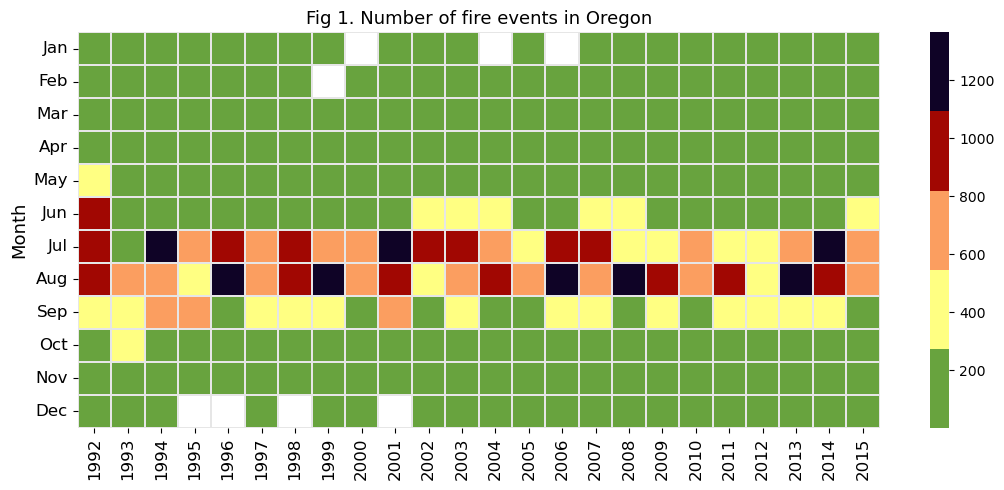

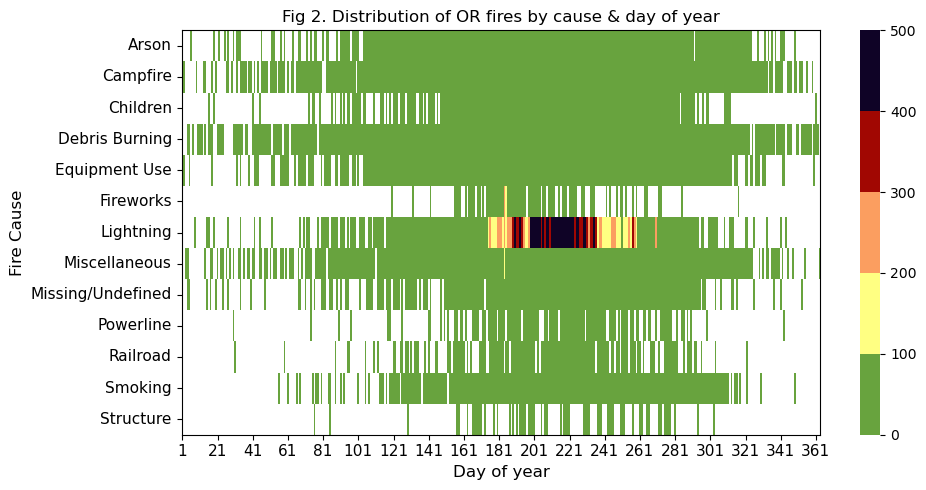

In [114]:
custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors

##################################################
##### 3. Monthly/seasonal fire frequency #####

df_freq_mon = df_OR.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
df_freq_mon.to_csv("wildfireData.csv")
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in Oregon', fontsize=13)
plt.tight_layout()

# plot fire frequency by cause and day of year
cause_by_doy = df_OR.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of OR fires by cause & day of year')
plt.tight_layout()


# Download and Extract Climate Data (ERAS)

In [153]:
import os

# Get the user directory within the current environment
env_name = 'musa-550-fall-2023'
env_user_dir = os.path.join(os.environ['CONDA_PREFIX'], 'envs', env_name)

print(f"User directory in {env_name} environment: {env_user_dir}")

User directory in musa-550-fall-2023 environment: C:\Users\shrey\mambaforge\envs\musa-550-fall-2023\envs\musa-550-fall-2023


# Assessing climate trends

In [232]:
bendWeather_up = pd.read_csv("./BendWeather_up.csv")

In [231]:
## CONVERT TIME STAMPS INTO COLUMNS
import pandas as pd
bendWeather = pd.read_csv("./BendWeather.csv")
# Function to handle different date formats
def convert_date(date_str):
    formats_to_try = ['%d/%m/%Y %H:%M:%S', '%m/%d/%Y %H:%M:%S']  # Add more formats if needed
    for fmt in formats_to_try:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return None  # If none of the formats match

# Apply the function to the 'interval60' column
bendWeather['interval60'] = bendWeather['interval60'].apply(convert_date)
bendWeather_up['interval60'] = bendWeather_up['interval60'].apply(convert_date)

# Extract day, month, year, and hour into separate columns
bendWeather['Day'] = bendWeather['interval60'].dt.day
bendWeather['Month'] = bendWeather['interval60'].dt.month
bendWeather['Year'] = bendWeather['interval60'].dt.year
bendWeather['Hour'] = bendWeather['interval60'].dt.hour

# Display the updated DataFrame with new columns
print(bendWeather.head(10))

AttributeError: Can only use .dt accessor with datetimelike values

In [233]:
bendWeather_up.head(10)


,interval60,Temperature,Precipitation,Wind_Speed,Dew_Point_Temp
0,2014-01-01,37.4,0.0,8,23.0
1,2014-01-01 01:00:00,35.6,0.0,5,23.0
2,2014-01-01 02:00:00,33.8,0.0,5,23.0
3,2014-01-01 03:00:00,32.0,0.0,6,24.8
4,2014-01-01 04:00:00,32.0,0.0,7,23.0
5,2014-01-01 05:00:00,32.0,0.0,7,23.0
6,2014-01-01 06:00:00,32.0,0.0,6,23.0
7,2014-01-01 07:00:00,28.4,0.0,5,24.8
8,2014-01-01 08:00:00,28.4,0.0,6,23.0
9,2014-01-01 09:00:00,28.4,0.0,5,23.0


# Analyzing Weather Patterns

In [155]:
# Annual Temperature
df_freq_mon = bendWeather.groupby(['Month', 'Temperature']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Annual Temperature Changes in Oregon', fontsize=13)
plt.tight_layout()

Error in callback <function flush_figures at 0x000001E9F9C4CAF0> (for post_execute):



KeyboardInterrupt



# Patterns in Wind Speed

In [156]:
# Annual Patterns in Wind Speed
df_freq_mon = bendWeather.groupby(['Month', 'Wind_Speed']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Annual Precipitation Patterns in Oregon', fontsize=13)
plt.tight_layout()
#plt.savefig(f'../Figures/Fig{counter_fig}.png', format='png', dpi=200)

KeyboardInterrupt: 

In [ ]:
alt.data_transformers.enable("vegafusion")
alt.Chart(bendWeather).mark_tick().encode(
    alt.X('Precipitation')
)

In [236]:
import pandas as pd

# Assuming 'interval60' is the column you want to clean in bendWeather_up DataFrame
bendWeather_up['interval60'] = bendWeather_up['interval60'].str.strip()  # Remove leading/trailing whitespaces
mask = bendWeather_up['interval60'].str.match(r'\d{4}-\d{2}-\d{2}$')  # Check if the values match the format "%Y-%m-%d"
bendWeather_up = bendWeather_up[mask]

# Convert the 'interval60' column to datetime
bendWeather_up['interval60'] = pd.to_datetime(bendWeather_up['interval60'])

# Merge the DataFrames
merged_df = pd.merge(df_OR_year, bendWeather_up, left_on='DISCOVERY_DATETIME', right_on='interval60', how='inner')

# Display the result
merged_df.head(10)


C:\Users\shrey\AppData\Local\Temp\ipykernel_49496\938298216.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,MONTH,DAY,geometry,DISDATE,DISCOVERY_DATETIME,interval60,Temperature,Precipitation,Wind_Speed,Dew_Point_Temp
0,1722149.0,300000215.0,FS-1525575,FED,FS-FIRESTAT,0412,Payette National Forest,095,095,EKW7,None,None,None,None,2014.0,2014-09-20,263.0,00:30:00,1.0,Lightning,2456921.5,264.0,1233,0.10,A,44.713056,-116.244444,ID,Adams,003,Adams,b'\x00\x01\xad\x10\x00\x00H\xdfJ\xfa\xa4\x0f]\...,09,20,POINT (-116.24444 44.71306),2014-09-20,2014-09-20,2014-09-20,62.6,0.0,5,44.6
1,1722156.0,300000222.0,FS-1523767,FED,FS-FIRESTAT,0412,Payette National Forest,035,035,EKW7,None,None,None,None,2014.0,2014-08-03,215.0,00:30:00,1.0,Lightning,2456873.5,216.0,1700,15.00,C,45.148889,-116.191111,ID,Adams,003,Adams,b'\x00\x01\xad\x10\x00\x00\x88\xd6\x17*;\x0c]\...,08,03,POINT (-116.19111 45.14889),2014-08-03,2014-08-03,2014-08-03,64.4,0.0,5,53.6
2,1738360.0,300075841.0,SFO-2014MTNWS000079,NONFED,ST-NASF,MTNWS,Northwestern Land Office,None,000079,None,None,None,None,None,2014.0,2014-08-03,215.0,00:14:00,1.0,Lightning,2456872.5,215.0,1130,0.01,A,48.348300,-114.133300,MT,Flathead,029,Flathead,b'\x00\x01\xad\x10\x00\x00\xa0#\xb9\xfc\x87\x8...,08,03,POINT (-114.13330 48.34830),2014-08-03,2014-08-03,2014-08-03,64.4,0.0,5,53.6
3,1770867.0,300116215.0,SFO-2014CACDFBTU010977,NONFED,ST-NASF,CABTU,Butte Unit,None,BTU010977,None,None,None,None,None,2014.0,2014-08-03,215.0,00:46:00,7.0,Arson,2456872.5,215.0,0100,1.00,B,39.515410,-121.605444,CA,BUTTE,007,Butte,b'\x00\x01\xad\x10\x00\x00\xcc\xe30\x98\xbff^\...,08,03,POINT (-121.60544 39.51541),2014-08-03,2014-08-03,2014-08-03,64.4,0.0,5,53.6
4,1722689.0,300000768.0,FS-1521365,FED,FS-FIRESTAT,0501,Angeles National Forest,057,36,H5V5,None,None,None,None,2014.0,2014-06-12,163.0,00:04:00,2.0,Equipment Use,2456820.5,163.0,0100,0.10,A,34.688611,-118.786667,CA,Los Angeles,037,Los Angeles,b'\x00\x01\xad\x10\x00\x004 )\xbfX\xb2]\xc0h\x...,06,12,POINT (-118.78667 34.68861),2014-06-12,2014-06-12,2014-06-12,64.4,0.0,6,42.8
5,1729108.0,300007357.0,W-668828,FED,DOI-WFMI,AKAFS,Alaska Fire Service,None,None,H5Y8,None,None,None,None,2014.0,2014-06-12,163.0,00:45:00,5.0,Debris Burning,2456820.5,163.0,0140,0.10,A,61.366700,-149.533300,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00\x9d^)\xcb\x10\xb1b\...,06,12,POINT (-149.53330 61.36670),2014-06-12,2014-06-12,2014-06-12,64.4,0.0,6,42.8
6,1722694.0,300000773.0,FS-1521712,FED,FS-FIRESTAT,0501,Angeles National Forest,064,43,EK1S,None,None,None,None,2014.0,2014-06-29,180.0,00:12:00,2.0,Equipment Use,2456837.5,180.0,0040,0.10,A,34.561389,-118.680556,CA,Los Angeles,037,Los Angeles,b'\x00\x01\xad\x10\x00\x00\xe4S\xe88\x8e\xab]\...,06,29,POINT (-118.68056 34.56139),2014-06-29,2014-06-29,2014-06-29,55.4,0.0,3,42.8
7,1722756.0,300000835.0,FS-1520755,FED,FS-FIRESTAT,0501,Angeles National Forest,004,1,EN0A,None,None,None,None,2014.0,2014-01-06,6.0,00:15:00,9.0,Miscellaneous,2456663.5,6.0,0302,4.00,B,34.153333,-117.922778,CA,Los Angeles,037,Los Angeles,b'\x00\x01\xad\x10\x00\x00\xd4\xa4\x88\xca\x0e...,01,06,POINT (-117.92278 34.15333),2014-01-06,2014-01-06,2014-01-06,21.2,0.0,0,12.2
8,1729656.0,300009798.0,W-665218,FED,DOI-WFMI,AZSCA,San Carlos Agency,1,None,H08F,None,None,None,None,2014.0,2014-01-06,6.0,00:11:00,4.0,Campfire,2456677.5,20.0,1600,3.50,B,33.334860,-110.447360,AZ,None,None,None,b'\x00\x01\xad\x10\x00\x00tb\xd6\x8b\xa1\x9c[\...,01,06,POINT (-110.44736 33.33486),2014-01-06,2014-01-06,2014-01-06,21.2,0.0,0,12.2
9,1748243.0,300088746.0,SFO-2014GAGAS-FY2014-Brantley-009,NONFED,ST-NASF,GAGAS,Georgia Forestry Commission,None,FY2014-Brantley-009,None,None,None,None,None,2014.0,2014-01-0

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File ~\mambaforge\envs\musa-550-fall-2023\lib\site-packages\flask\app.py:1484, in Flask.full_dispatch_request(self=<Flask '__main__'>)
   1482     rv = self.preprocess_request()
   1483     if rv is None:
-> 1484         rv = self.dispatch_request()
        self = <Flask '__main__'>
        rv = None
   1485 except Exception as e:
   1486     rv = self.handle_user_exception(e)

File ~\mambaforge\envs\musa-550-fall-2023\lib\site-packages\flask\app.py:1469, in Flask.dispatch_request(self=<Flask '__main__'>)
   1467 # otherwise dispatch to the handler for that endpoint
   1468 view_args: dict[str, t.Any] = req.view_args  # type: ignore[assignment]
-> 1469 return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
        rule = <Rule '/_dash-layout' (HEAD, GET, OPTIONS) -> /_dash-layout>
        view_args = {}
        self.vi

In [272]:
# not it
import folium
import plotly.express as px
import panel as pn
from IPython.display import HTML

# Assuming df_OR_year is your DataFrame with fire data
# Assuming merged_df is the merged DataFrame with weather data

# Create an interactive map using folium
n = folium.Map(location=[merged_df['LATITUDE'].mean(), merged_df['LONGITUDE'].mean()], zoom_start=6)

# Add markers for each fire incident
for index, row in merged_df.iterrows():
    popup_text = f"Fire Size: {row['FIRE_SIZE']}<br>Date: {row['DISCOVERY_DATETIME']}<br>"
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_text).add_to(m)

# Convert the folium map to HTML
folium_map_html = n._repr_html_()

# Create a bar chart using plotly express


dashboard = pn.Column(
    HTML(folium_map_html)
    # HTML(bar_chart_html, height=300),
)

# Launch the dashboard
dashboard.show()

Launching server at http://localhost:61621


In [276]:
import folium
from folium.plugins import MarkerCluster

# Load US states boundaries GeoJSON data
#us_states_geojson = 'states.json'  # Replace with the actual file path

# Create a folium map centered at North America
n = folium.Map(location=[44, -110], zoom_start=4)

# Add US states boundaries to the map
#folium.GeoJson(
 #   us_states_geojson,
  #  name='geojson'
#).add_to(n)

# Create a MarkerCluster layer for wildfires
marker_cluster = MarkerCluster().add_to(n)

# Add markers for each state
for index, row in merged_df.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"Precipitation: {row['Precipitation']}\nFire Size: {row['FIRE_SIZE']:.2f}",
        icon=None,  # You can customize the icon here
    ).add_to(marker_cluster)

# Display the map
n.save('wildfires_map.html')  # Save the map as an HTML file

n